In [1]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio
import nibabel as nib
import SimpleITK as sitk
from scipy.stats import iqr
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import multiprocessing as mp

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import random

import torchvision
from torchvision import models
from torchvision import transforms
from sklearn import metrics


import yaml
from dataset.hmri_dataset import HMRIDataModule, HMRIDataModuleDownstream, HMRIControlsDataModule, HMRIPDDataModule
from models.pl_model import Model, ContrastiveLearning, ModelDownstream
from utils.utils import get_pretrained_model
from utils.utils import save_nifti_from_array, crop_img
from utils.general_utils import save_sitk_from_nda
from tqdm import tqdm
this_path = Path().resolve()


In [2]:
def rename_labels(df, atlas_type: str = 'pd25'):

    if atlas_type == 'pd25':
        replace_dict = {1: 'left_red_nucleus',
                        3: 'left_substantia_nigra',
                        5: 'left_subthalamic_nucleus',
                        7: 'left_caudate',
                        9: 'left_putamen',
                        11: 'left_globus_pallidus_externa',
                        13: 'left_globus_pallidus_interna',
                        15: 'left_thalamus',
                        2: 'right_red_nucleus',
                        4: 'right_substantia_nigra',
                        6: 'right_subthalamic_nucleus',
                        8: 'right_caudate',
                        10: 'right_putamen',
                        12: 'right_globus_pallidus_externa',
                        14: 'right_globus_pallidus_interna',
                        16: 'right_thalamus',}
        df.label.replace(replace_dict, inplace=True)
        
        return df
    else:
        replace_dict = {0: 'background',
                        2: 'left_cerebral_white_matter',
                        3: 'left_cerebral_cortex',
                        4: 'left_lateral_ventricle',
                        5: 'left_inferior_lateral_ventricle',
                        7: 'left_cerebellum_white_matter',
                        8: 'left_cerebellum_cortex',
                        10: 'left_thalamus',
                        11: 'left_caudate',
                        12: 'left_putamen',
                        13: 'left_pallidum',
                        14: 'third_ventricle',
                        15: 'fourth_ventricle',
                        16: 'brain_stem',
                        17: 'left_hippocampus',
                        18: 'left_amygdala',
                        24: 'csf',
                        26: 'left_accumbens_area',
                        28: 'left_ventral_diencephalon',
                        41: 'right_cerebral_white_matter',
                        42: 'right_cerebral_cortex',
                        43: 'right_lateral_ventricle',
                        44: 'right_inferior_lateral_ventricle',
                        46: 'right_cerebellum_white_matter',
                        47: 'right_cerebellum_cortex',
                        49: 'right_thalamus',
                        50: 'right_caudate',
                        51: 'right_putamen',
                        52: 'right_pallidum',
                        53: 'right_hippocampus',
                        54: 'right_amygdala',
                        58: 'right_accumbens_area',
                        60: 'right_ventral_diencephalon'}
        df.label.replace(replace_dict, inplace=True)

        return df

### General statistics (for XAI, qMRI, or RE maps)

In [8]:
def get_statistics_from_map(xai_map: np.ndarray, subject: str, group: str, atlas_type: str = 'synthseg'):
    # get atlas nda
    # atlas_nda = get_atlas_nda(subject, group)
    if atlas_type == 'synthseg':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/ss_cropped_{subject}_mT1w_synthseg.nii').get_fdata()
    if atlas_type == 'pd25':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii').get_fdata()
    # get unique values in atlas
    atlas_vals = np.unique(atlas_nda.astype(int))
    stats = []
    for label in atlas_vals:
        map_stats = {}
        map_stats['label'] = label
        map_stats['group'] = group
        map_stats['atlas'] = atlas_type
        map_stats['subject'] = subject     
        masked_map = xai_map[atlas_nda == label]
        map_stats['volume']= len(masked_map)
        map_stats['mean'] = np.mean(masked_map)
        map_stats['std'] = np.std(masked_map)
        map_stats['median'] = np.median(masked_map)
        map_stats['max'] = np.max(masked_map)
        map_stats['min'] = np.min(masked_map)
        map_stats['iqr'] = iqr(masked_map)
        stats.append(map_stats)

    return pd.DataFrame(stats)

In [3]:
subject = 'sub-015'
# pilot_path = Path(f"/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01")
# img_can = nib.load(str(pilot_path/'sub-015_R2s_WLS1_ps5_stride3_og_img.nii.gz')).get_fdata()
img_can = nib.load(Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-015/Results/brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1_w.nii')).get_fdata()
df = get_statistics_from_map(img_can, subject, 'PD', atlas_type='pd25')
df['map_type'] = 'R2s'
df

,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,pd25,sub-015,4712758,6.562513,12.696630,0.000000,70.000000,0.000000,13.255274,R2s
1,1,PD,pd25,sub-015,155,33.407792,4.025911,33.596752,42.867149,22.137659,4.784662,R2s
2,2,PD,pd25,sub-015,185,33.688546,4.101685,34.227268,41.665302,22.112682,5.803352,R2s
3,3,PD,pd25,sub-015,350,34.733783,5.883500,34.206980,54.081333,15.967494,7.568829,R2s
4,4,PD,pd25,sub-015,392,34.299917,5.569169,34.104025,57.009399,19.105022,7.168189,R2s
5,5,PD,pd25,sub-015,65,33.518229,4.903578,33.629230,43.601055,21.663513,7.164928,R2s
6,6,PD,pd25,sub-015,60,34.924594,3.595164,34.435980,43.314087,27.379469,3.622738,R2s
7,7,PD,pd25,sub-015,4164,24.212384,6.410780,24.019057,70.000000,1.694561,6.086370,R2s
8,8,PD,pd25,sub-015,3810,23.887278,6.180644,23.597692,70.000000,2.858907,6.114173,R2s
9,9,PD,pd25,sub-015,3982,28.541692,5.516172,28.231790,54.514313,0.000000,7.102302,R2s


In [4]:
# stats per qMRI map
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
subjs_to_drop = ['sub-058', 'sub-016']
for drop_id in subjs_to_drop:
    md_df.drop(md_df[md_df.id == drop_id].index, inplace=True)
md_df.reset_index(drop=True, inplace=True)

maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']

dfs = pd.DataFrame()
progress_bar = tqdm(range(len(md_df)), total=len(md_df), desc='Processing maps', ncols=110)
for i in progress_bar:
    subject = md_df['id'][i]
    if md_df['group'][i] == 0:
        group = 'HC'
    else:   
        group = 'PD'
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    for map in maps:
        img_map = nib.load(str(pilot_path/f'brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map}_w.nii')).get_fdata()
        df = get_statistics_from_map(img_map, subject, group, atlas_type='synthseg')
        df['map_type'] = map
        dfs = pd.concat([dfs, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
dfs.to_csv('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/dfs/pd25_stats.csv', index=False)
dfs

Processing maps: 100%|████████████████████████████████████████████████████████| 70/70 [04:07<00:00,  3.54s/it]


,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,synthseg,sub-003,3326168,0.004033,0.059349,0.000000,2.000000,0.000000,0.000000,MTsat
1,2,PD,synthseg,sub-003,203932,1.382839,0.259516,1.431302,2.000000,0.000000,0.318242,MTsat
2,3,PD,synthseg,sub-003,236564,0.776208,0.279045,0.819511,2.000000,0.000000,0.324698,MTsat
3,4,PD,synthseg,sub-003,23593,0.070589,0.123766,0.025063,1.218305,0.000000,0.063837,MTsat
4,5,PD,synthseg,sub-003,951,0.150472,0.163004,0.100461,0.937812,0.000000,0.202447,MTsat
...,...,...,...,...,...,...,...,...,...,...,...,...
9235,52,PD,synthseg,sub-074,1747,75.574689,3.676946,75.369843,90.097977,63.798927,4.595238,PD_R2scorr
9236,53,PD,synthseg,sub-074,4495,78.557350,5.371549,78.796303,120.000000,53.914570,6.623413,PD_R2scorr
9237,54,PD,synthseg,sub-074,2069,79.177872,4.558826,79.045662,99.860344,65.524323,6.162407,PD_R2scorr
9238,58,PD,synthseg,sub-074,722,77.168637,7.328216,76.842819,120.000000,58.141071,7.149042,PD_R2scorr


### Group differences XAI maps

In [ ]:
import torchio as tio

In [3]:
def scale_image_w_clip(image, min_percentile=0.2, max_percentile=99.8):
    """Scale image between 0 and 1."""
    image_min = np.percentile(image, min_percentile)
    image_max = np.percentile(image, max_percentile)
    image = np.clip(image, image_min, image_max)
    image = (image - image_min) / (image_max - image_min)
    return image

def min_max_scale(image):
    """Scale image between 0 and 1."""
    image_min = np.min(image)
    image_max = np.max(image)
    image = (image - image_min) / (image_max - image_min)
    return image

In [3]:
hc_subjects = ['sub-036', 'sub-030', 'sub-032', 'sub-050']
pd_subjects = ['sub-041', 'sub-035', 'sub-071', 'sub-015']
maps = ['ig', 'occ']
atlas_type = 'pd25'
map_type = 'R2s_WLS1'
do_scale = True

if do_scale:
    df_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/dfs/statistics_{atlas_type}_{map_type}.csv')
else:
    df_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/dfs/statistics_{atlas_type}_{map_type}_noscale.csv')
if df_path.exists():
    dfs = pd.read_csv(df_path)
else:
    dfs = pd.DataFrame()
    for subject in hc_subjects:
        for re_map in maps:
            base_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/xai')
            if re_map == 'ig':
                map_path = base_path / f'odim_final_{subject}_{map_type}_IntegratedGrads_nsteps_200_result.nii.gz'
            else:
                map_path = base_path / f'odim_final_{subject}_{map_type}_occ_s5_ps8_occ_result.nii.gz'
            map_img = nib.load(str(map_path)).get_fdata()
            if do_scale:
                map_img = min_max_scale(map_img)
                # map_img = scale_image_w_clip(map_img)
            df = get_statistics_from_map(map_img, subject, 'HC', atlas_type=atlas_type)
            df['map_type'] = re_map
            df['scale'] = do_scale
            dfs = pd.concat([dfs, df], axis=0)
        # break

    for subject in pd_subjects:
        for re_map in maps:
            base_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/xai')
            if re_map == 'ig':
                map_path = base_path / f'odim_final_{subject}_{map_type}_IntegratedGrads_nsteps_200_result.nii.gz'
            else:
                map_path = base_path / f'odim_final_{subject}_{map_type}_occ_s5_ps8_occ_result.nii.gz'
            map_img = nib.load(str(map_path)).get_fdata()
            if do_scale:
                map_img = min_max_scale(map_img)
                # map_img = scale_image_w_clip(map_img)
            df = get_statistics_from_map(map_img, subject, 'PD', atlas_type=atlas_type) 
            df['map_type'] = re_map
            df['scale'] = do_scale
            dfs = pd.concat([dfs, df], axis=0)
        # break
    dfs.reset_index(drop=True, inplace=True)
    dfs.to_csv(df_path, index=False)

dfs = rename_labels(dfs, atlas_type)

In [4]:
fos_type = 'mean'
test_stats = []
for map in maps: 
    for label in dfs.label.unique():
        # label = 26
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        # print(f'Processing {map} {label}')
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                   df_lab.loc[df_lab.group == 'HC', fos_type].values)
        t_test, t_p_value = ttest_ind(df_lab.loc[df_lab.group == 'PD', fos_type].values, 
                                      df_lab.loc[df_lab.group == 'HC', fos_type].values,
                                      equal_var=True,
                                      permutations=1000)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        test_dict['t_test'] = t_test
        test_dict['t_p_value'] = t_p_value
        test_stats.append(test_dict)
        
test_stats = pd.DataFrame(test_stats)

alpha = 0.05
bestfos = test_stats.loc[(test_stats.p_value < alpha) & (test_stats.t_p_value < alpha), :] # (test_stats.p_value < alpha) & 
bestfos.reset_index(drop=True, inplace=True)
bestfos


,map,fos_type,label,f_oneway,p_value,t_test,t_p_value
0,ig,mean,left_globus_pallidus_externa,16.387904,0.006740,4.048198,0.028571
1,ig,mean,right_globus_pallidus_externa,7.855617,0.031050,2.802787,0.028571
2,ig,mean,left_globus_pallidus_interna,12.153809,0.013043,3.486231,0.028571
3,ig,mean,right_globus_pallidus_interna,7.853158,0.031068,2.802349,0.028571


In [6]:
def rename_labels_for_plot(df, atlas_type: str = 'pd25'):

    if atlas_type == 'pd25':
        replace_dict = {'left_red_nucleus': 'left RN',
                        'left_substantia_nigra': 'left SNc',
                        'left_subthalamic_nucleus': 'left STN',
                        'left_caudate': 'left Cau',
                        'left_putamen': 'left Put',
                        'left_globus_pallidus_externa': 'left GPe',
                        'left_globus_pallidus_interna': 'left GPi',
                        'left_thalamus': 'left Th',
                        'right_red_nucleus': 'right RN',
                        'right_substantia_nigra': 'right SNc',
                        'right_subthalamic_nucleus': 'right STN',
                        'right_caudate': 'right Cau',
                        'right_putamen': 'right Put',
                        'right_globus_pallidus_externa': 'right GPe',
                        'right_globus_pallidus_interna': 'right GPi',
                        'right_thalamus': 'right Th'}
        df.label.replace(replace_dict, inplace=True)
        
        return df
    else:
        # replace_dict = {0: 'background',
        #                 2: 'left_cerebral_white_matter',
        #                 3: 'left_cerebral_cortex',
        #                 4: 'left_lateral_ventricle',
        #                 5: 'left_inferior_lateral_ventricle',
        #                 7: 'left_cerebellum_white_matter',
        #                 8: 'left_cerebellum_cortex',
        #                 10: 'left_thalamus',
        #                 11: 'left_caudate',
        #                 12: 'left_putamen',
        #                 13: 'left_pallidum',
        #                 14: 'third_ventricle',
        #                 15: 'fourth_ventricle',
        #                 16: 'brain_stem',
        #                 17: 'left_hippocampus',
        #                 18: 'left_amygdala',
        #                 24: 'csf',
        #                 26: 'left_accumbens_area',
        #                 28: 'left_ventral_diencephalon',
        #                 41: 'right_cerebral_white_matter',
        #                 42: 'right_cerebral_cortex',
        #                 43: 'right_lateral_ventricle',
        #                 44: 'right_inferior_lateral_ventricle',
        #                 46: 'right_cerebellum_white_matter',
        #                 47: 'right_cerebellum_cortex',
        #                 49: 'right_thalamus',
        #                 50: 'right_caudate',
        #                 51: 'right_putamen',
        #                 52: 'right_pallidum',
        #                 53: 'right_hippocampus',
        #                 54: 'right_amygdala',
        #                 58: 'right_accumbens_area',
        #                 60: 'right_ventral_diencephalon'}
        # df.label.replace(replace_dict, inplace=True)

        return df

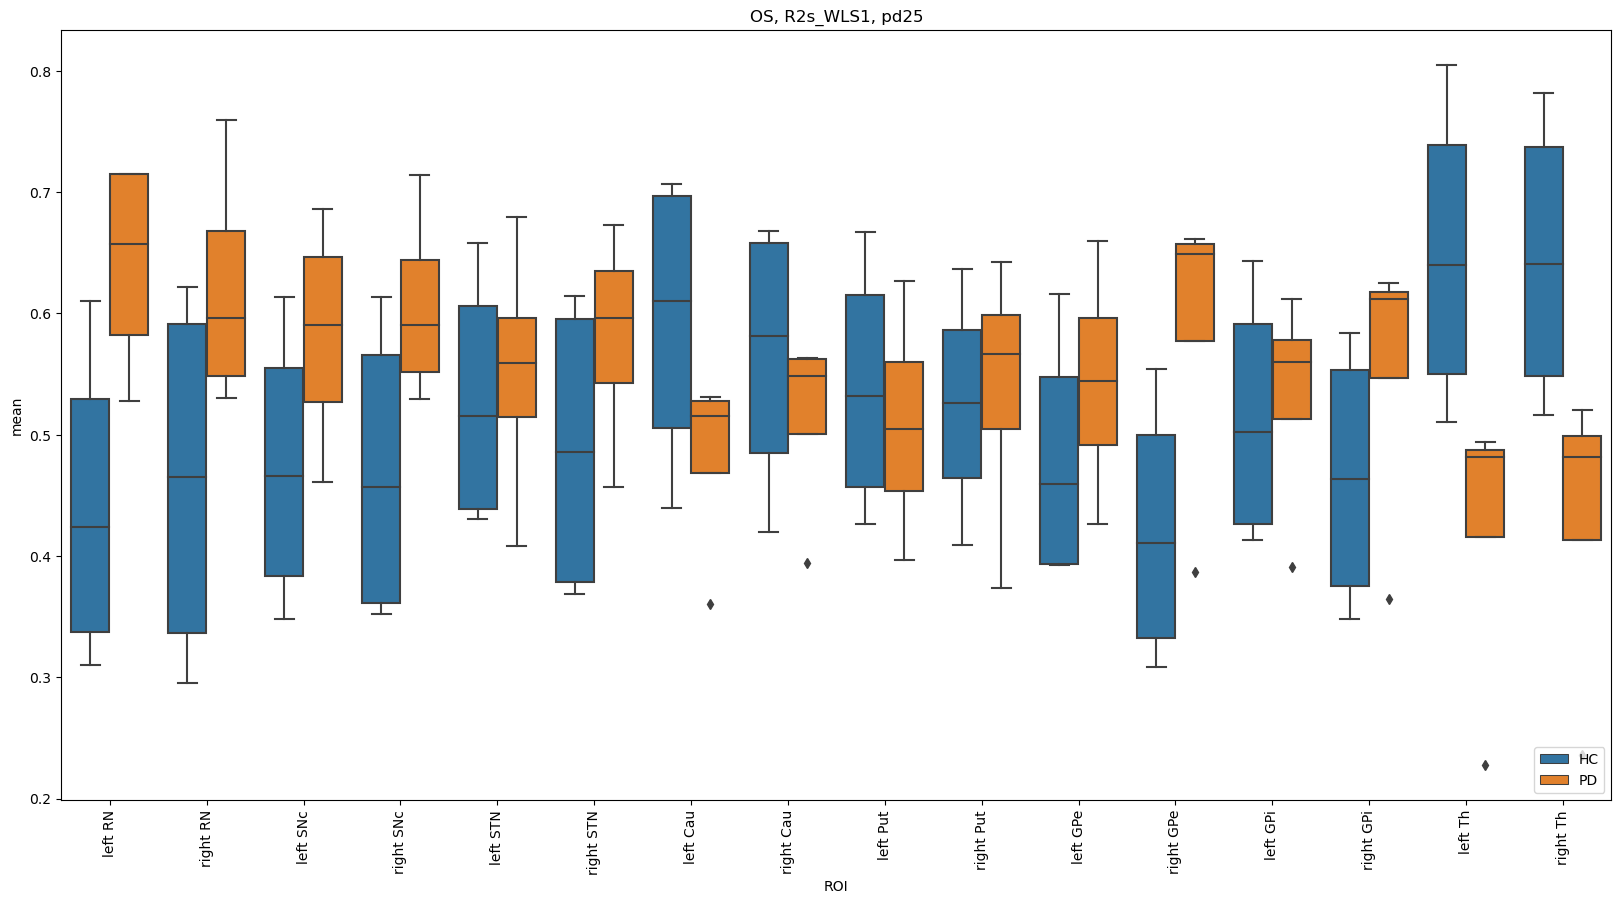

In [11]:
df_to_plot = rename_labels_for_plot(dfs.loc[(dfs.map_type == 'occ') & (dfs.label != 0) , :] , atlas_type) # & (dfs.label.isin(bestfos.loc[bestfos.map == 'ig', :].label.unique()))  & (dfs.label != 0)
plt.figure(figsize=(20,10))
sns.boxplot(x='label', y='mean', hue='group', data=df_to_plot) # & (dfs.label.isin(bestfos.label.unique()))
# plt.xticks(ticks=[0, 1, 2, 3], labels=['left cerebral \n white matter', 'left lateral \n ventricle', 'right cerebral \n white matter', 'right lateral \n ventricle']) # ,rotation=90
# plt.xticks(ticks=[0, 1, 2], labels=['left pallidum', 'right caudate', 'right pallidum']) # ,rotation=90
plt.xticks(rotation=90)
# max_mean = df_to_plot.groupby('label')['mean'].max().max()

# for i, row in bestfos.loc[bestfos.map == 'occ', :].iterrows():
#     # statistical annotation
#     i = i-3
#     x1, x2 = i-0.2, i+0.2 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#     y, h, col = max_mean + 0.01, 0.01, 'k'
#     p_value_to_plot = row.p_value
#     plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     plt.text((x1+x2)*.5, y+h+0.002, f"P = {p_value_to_plot:.3f}", ha='center', va='bottom', color=col)
#     # break

# plt.ylim(0.3, max_mean+0.05)
plt.xlabel('ROI')
plt.title(f'OS, {map_type}, {atlas_type}')
plt.legend(loc="lower right")
plt.show()